# Text Feature Extraction From Hidden States

> This notebook shows how to extract and utilize the hidden states of a Roberta language model for a variety of tasks

- skip_showdoc: true
- skip_exec: true

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
import os

In [ ]:
#This will specify a (or a list) of GPUs for training
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [ ]:
from that_nlp_library.text_transformation import *
from that_nlp_library.text_augmentation import *
from that_nlp_library.text_main_lm import *
from that_nlp_library.utils import seed_everything
from that_nlp_library.model_lm_main import *

In [ ]:
from underthesea import text_normalize
from functools import partial
from pathlib import Path
from transformers import AutoTokenizer, AutoConfig, AutoModelForMaskedLM
from datasets import load_dataset
import pandas as pd
import numpy as np
from transformers import DataCollatorForLanguageModeling

# Finetune a Roberta Language Model (with line-by-line tokenization)

## Create a TextDataLMController object

We will reuse the data and the preprocessings in [this tutorial](https://anhquan0412.github.io/that-nlp-library/text_main_lm.html) 

In order to extract a feature vector from a review sentence in the dataset, we can directly use pretrained models such as Roberta, GPT2, ... But if our dataset is vastly different from the datasets these pretrained models are trained on, we can finetune these pretrained models on our dataset before extracting the feature vector. And that's exactly what we are going to do now.

In [ ]:
dset = load_dataset('sample_data',data_files=['Womens_Clothing_Reviews.csv'],split='train')
ddict = dset.train_test_split(test_size=0.2,seed=42)
ddict['validation'] = ddict['test']
del ddict['test']

In [ ]:
# For now, we will filter missing review text rows here instead of relying the data controler
ddict = ddict.filter(lambda x: x['Review Text'] is not None)

In [ ]:
ddict

DatasetDict({
    train: Dataset({
        features: ['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name'],
        num_rows: 18111
    })
    validation: Dataset({
        features: ['Clothing ID', 'Age', 'Title', 'Review Text', 'Rating', 'Recommended IND', 'Positive Feedback Count', 'Division Name', 'Department Name', 'Class Name'],
        num_rows: 4530
    })
})

In [ ]:
tdc = TextDataLMController(ddict,
                         main_text='Review Text',
                         metadatas='Title',
                         content_transformations=[text_normalize,str.lower],
                         seed=42,
                         verbose=True
                        )

Define our tokenizer for Roberta

In [ ]:
_tokenizer = AutoTokenizer.from_pretrained('roberta-base')

/home/quan/anaconda3/envs/nlp_dev/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Process and tokenize our dataset (using line-by-line tokenization)

In [ ]:
block_size=112
tdc.process_and_tokenize(_tokenizer,line_by_line=True,max_length=block_size) 
# set max_length=-1 if you want the data collator to pad

-------------------- Start Main Text Processing --------------------
----- Metadata Simple Processing & Concatenating to Main Content -----
Done
-------------------- Text Transformation --------------------
----- text_normalize -----
----- lower -----
Done
-------------------- Train Test Split --------------------
Validation split already exists
Done
-------------------- Dropping unused features --------------------
Done
- Number of rows leaked: 2, which is 0.01% of training set
Filtering leaked data out of training set...


Filter (num_proc=4):   0%|          | 0/18111 [00:00<?, ? examples/s]

Done
-------------------- Shuffling and flattening train set --------------------


Flattening the indices (num_proc=4):   0%|          | 0/18109 [00:00<?, ? examples/s]

Done
-------------------- Tokenization --------------------


Map (num_proc=4):   0%|          | 0/18109 [00:00<?, ? examples/s]

Map (num_proc=4):   0%|          | 0/4530 [00:00<?, ? examples/s]

Done


In [ ]:
tdc.main_ddict

DatasetDict({
    train: Dataset({
        features: ['Title', 'Review Text', 'input_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 18109
    })
    validation: Dataset({
        features: ['Title', 'Review Text', 'input_ids', 'attention_mask', 'special_tokens_mask'],
        num_rows: 4530
    })
})

And set the data collator

In [ ]:
tdc.set_data_collator(is_mlm=True,mlm_prob=0.15)

## Initialize and train Roberta Language Model

In [ ]:
_config = AutoConfig.from_pretrained('roberta-base',vocab_size=len(_tokenizer))

In [ ]:
_model = language_model_init(AutoModelForMaskedLM,
                             config=_config,
                             cpoint_path='roberta-base',
                             seed=42
                            )

Total parameters: 124697433
Total trainable parameters: 124697433


Create a model controller

In [ ]:
controller = ModelLMController(_model,data_store=tdc,seed=42)

And we can start training our model

In [ ]:
lr = 1e-4
bs=32
wd=0.01
epochs= 6
warmup_ratio=0.25
controller.fit(epochs,lr,
               batch_size=bs,
               weight_decay=wd,
               warmup_ratio=warmup_ratio,
               save_checkpoint=False,
              )


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.502509,0.657702
2,1.706200,1.509666,0.656255
3,1.706200,1.423058,0.671800
4,1.476100,1.344976,0.684443
5,1.476100,1.309737,0.691151
6,1.308800,1.293480,0.694945


Perplexity on validation set: 3.634


Finetuning from a pretrained model results in a massive improvement in terms of metrics

In [ ]:
controller.trainer.model.save_pretrained('./sample_weights/roberta_lm_model')

## Extract hidden states from model

### From raw texts

We can extract a feature vector from a raw text

In [ ]:
# including the `Title` entry, because we have it as our metadata in the data controller
inp1 = {'Title':'Flattering',
        'Review Text': "Love this skirt. The detail is amazing. Runs small I ordered a 12 I'm usually a 10, but still a little snug"
       }

There's a crucial step we have to do: set `output_hidden_states` to be `True`, so that the model can return them back for us to extract

In [ ]:
_config = AutoConfig.from_pretrained('./sample_weights/roberta_lm_model',output_hidden_states=True)

In [ ]:
trained_model = language_model_init(AutoModelForMaskedLM,
                                    cpoint_path='./sample_weights/roberta_lm_model',
                                    config=_config
                                   )

controller2 = ModelLMController(trained_model,data_store=tdc,seed=42)

Total parameters: 124697433
Total trainable parameters: 124697433


When `output_hidden_states` is set to `True`, the model will return a variable called `hidden_states`, which construct of hidden states of each layer in RoBERTa-base model. We only want the last layer's hidden states (index -1), and we want the hidden vector of the first token of this layer (the `[CLS]` token)

In [ ]:
hidden_from_ip1 = controller2.get_hidden_states_from_raw_text(inp1,
                                                              state_name='hidden_states',
                                                              state_idx=[-1,0]
                                                             )

-------------------- Start Test Set Transformation --------------------
----- Metadata Simple Processing & Concatenating to Main Content -----


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done
-------------------- Text Transformation --------------------
----- text_normalize -----


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

----- lower -----


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done
-------------------- Tokenization --------------------


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

Done


Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
hidden_from_ip1

Dataset({
    features: ['Title', 'Review Text', 'input_ids', 'attention_mask', 'special_tokens_mask', 'hidden_states'],
    num_rows: 1
})

The lenght of the hidden vector (our feature vector) from the first token of the last layer of RoBERTa is 768

In [ ]:
hidden_from_ip1['hidden_states'].shape

(1, 768)

### From train (or validation) set

Similarly, we can extract feature vectors for all sentences in our existing set. We will do some experiments on the validation set for now. As an exercise, you can repeat all the experiments with the training set (All you have to do is to change `ds_type` to `"train"`)

In [ ]:
_config = AutoConfig.from_pretrained('./sample_weights/roberta_lm_model',output_hidden_states=True)

trained_model = language_model_init(AutoModelForMaskedLM,
                                    cpoint_path='./sample_weights/roberta_lm_model',
                                    config=_config
                                   )

controller2 = ModelLMController(trained_model,data_store=tdc,seed=42)

Total parameters: 124697433
Total trainable parameters: 124697433


In [ ]:
hidden_from_val = controller2.get_hidden_states(ds_type='validation',
                                                 state_name='hidden_states',
                                                 state_idx=[-1,0]
                                                )

Map:   0%|          | 0/4530 [00:00<?, ? examples/s]

In [ ]:
hidden_from_val

Dataset({
    features: ['Title', 'Review Text', 'input_ids', 'attention_mask', 'special_tokens_mask', 'hidden_states'],
    num_rows: 4530
})

In [ ]:
hidden_from_val['hidden_states'].shape

(4530, 768)

# What can we do with feature vectors?

## Dimensionality Reduction

Typically for dimensionality reduction, the two main downstream tasks we can perform on the reduced-dimension data is either for visualization, or as an input of simpler machine learning models (regression, tree-related algorithms)

For dimensionality reduction, it’s important to determine the target number of lower dimensions that we will perform on the original data. We will use a popular algorithm called PCA, thus those dimensions are the principal components (PC). Thus, we can use the explained variance ratio (calculated from PC’s’ eigenvalue) to determine the amount of PC needed for our dimension reduction task

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def plot_cummulative_variance(X,figsize=(6,4),dim_to_visualize=None):
    if dim_to_visualize is None: dim_to_visualize = X.shape[1]
    _pca = PCA(svd_solver='full',random_state=42)
    _tmp = _pca.fit_transform(X)
    fig,ax = plt.subplots(figsize=figsize)
    ax.bar(1+np.arange(dim_to_visualize),_pca.explained_variance_ratio_[:dim_to_visualize],color='maroon')
    ax.set_ylabel('Explained Variance')

    
    ax2 = ax.twinx()
    ax2.plot(1+np.arange(dim_to_visualize),np.cumsum(_pca.explained_variance_ratio_[:dim_to_visualize]),label='Cummulative line',color='blue')
    ax2.set_xlabel('n_components')
    ax2.set_ylabel('Cummulative Explained Variance')
    ax2.legend(loc='upper right')
    plt.show()

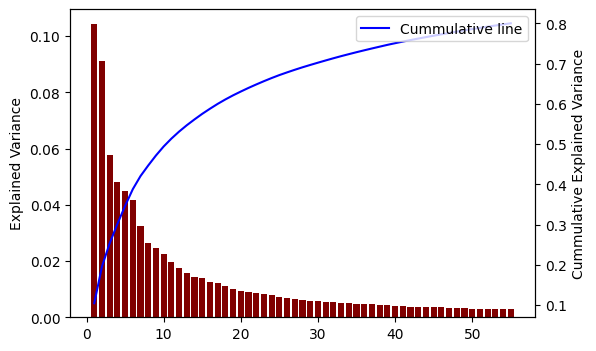

In [ ]:
plot_cummulative_variance(hidden_from_val['hidden_states'],dim_to_visualize=55)

 we can achieve roughly 80% total variance with only ~55 components (out of 768, which is only ~7% of data). The first 3 PC are the most important PC with the highest explained variance.

Let's try to visualize the first 3 PCs

In [ ]:
_pca = PCA(svd_solver='full',n_components=3,random_state=42)
_pca_coord = _pca.fit_transform(hidden_from_val['hidden_states'])

In [ ]:
pca_df = pd.DataFrame(_pca_coord,columns=['pc1','pc2','pc3'])

In [ ]:
pca_df['DN']=ddict['validation']['Department Name']
pca_df['DN'].fillna('Tops',inplace=True)

/tmp/ipykernel_51605/3688443385.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  pca_df['DN'].fillna('Tops',inplace=True)


<Axes: xlabel='pc2', ylabel='pc3'>

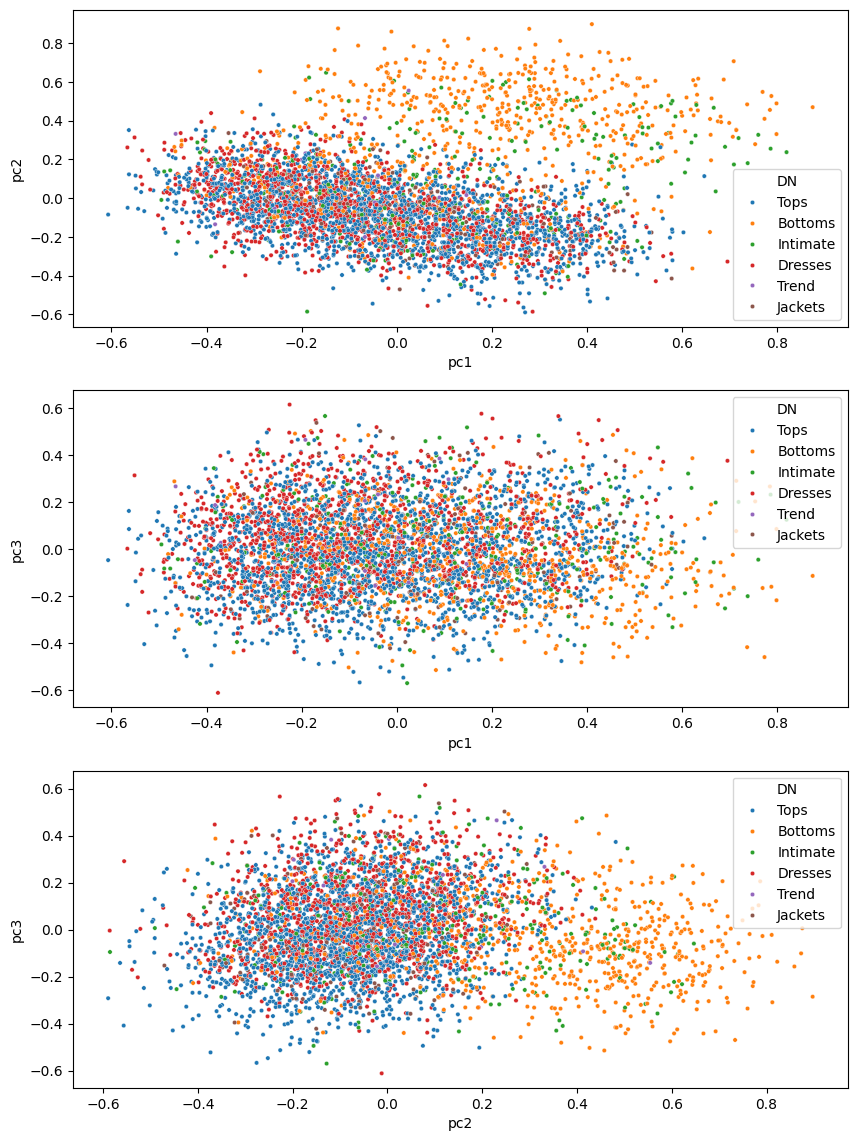

In [ ]:
fig,axs = plt.subplots(3,1,figsize=(10,14))
sns.scatterplot(data=pca_df,x='pc1',y='pc2',hue='DN',ax=axs[0],s=10)
sns.scatterplot(data=pca_df,x='pc1',y='pc3',hue='DN',ax=axs[1],s=10)
sns.scatterplot(data=pca_df,x='pc2',y='pc3',hue='DN',ax=axs[2],s=10)

We can somewhat distinguish a clear cluster when visualizing PC1 and PC3 on the top right. Combining with the `Department Name`, this cluster contains mostly "Bottoms" and "Intimiate" clothing items. Therefore, using these PCs, we can build a simple classification model to classify `Department Name`

## Sentence Similarity

When each sentence is represented by a dense feature vector, we can perform one of the popular task of sentence similarity: which sentences are the most similar to a given sentence? In this experiment, we will use [FAISS](https://faiss.ai/index.html) library, which is designed specifically for efficient similarity search and clustering of dense vectors

In [ ]:
import faiss
import time
import pandas as pd
import numpy as np
from datasets import load_from_disk

In [ ]:
def faiss_find_NN(index,X,k):
    tic = time.perf_counter()
    D, I = index.search(X, k=k)  
    toc = time.perf_counter()
    print(f"Execution time: {toc - tic:0.4f} seconds")
    return I,D

def faiss_prepare_gpu_index(X):
    res = faiss.StandardGpuResources()    
    index = faiss.IndexFlatL2(X.shape[1])
    gpu_index = faiss.index_cpu_to_gpu(res, 0, index)
    gpu_index.add(X)
    return gpu_index

    

def faiss_prepare_gpu_index_fast(X,nlist,nprobe=1):
    """
    https://github.com/facebookresearch/faiss/wiki/Faster-search
    - nlist parameter in the IndexIVFFlat index in Faiss refers to the number of Voronoi cells, 
    or clusters, that the index uses to partition the vector space.
    
    - nprobe parameter specifies the number of cells to visit during the search, 
    can be used in conjunction with nlist to further fine-tune the performance of the index. 
    
    For example, you can increase nlist to speed up the search 
    and then increase nprobe to compensate for the potential decrease in accuracy.
    """
    res = faiss.StandardGpuResources()
    d = X.shape[1]
    quantizer = faiss.IndexFlatL2(d)
    index = faiss.IndexIVFFlat(quantizer,d,nlist)
    assert not index.is_trained
    index.train(X)
    assert index.is_trained
    
    index.add(X)
    index.nprobe = nprobe
    gpu_index = faiss.index_cpu_to_gpu(res,0,index)
    return gpu_index

We will produce the feature vectors for the entire dataset

In [ ]:
full_dset = load_dataset('sample_data',data_files=['Womens_Clothing_Reviews.csv'],split='train')
# For now, we will filter missing review text rows here instead of relying the data controler
full_dset = full_dset.filter(lambda x: x['Review Text'] is not None)

In [ ]:
_config = AutoConfig.from_pretrained('./sample_weights/roberta_lm_model',output_hidden_states=True)

trained_model = language_model_init(AutoModelForMaskedLM,
                                    cpoint_path='./sample_weights/roberta_lm_model',
                                    config=_config
                                   )

controller2 = ModelLMController(trained_model,data_store=tdc,seed=42)

Total parameters: 124697433
Total trainable parameters: 124697433


In [ ]:
all_hiddens = controller2.get_hidden_states_from_raw_dset(dset=full_dset,
                                                          state_name='hidden_states',
                                                          state_idx=[-1,0])

-------------------- Start Test Set Transformation --------------------
----- Metadata Simple Processing & Concatenating to Main Content -----


Map (num_proc=4):   0%|          | 0/22641 [00:00<?, ? examples/s]

Done
-------------------- Text Transformation --------------------
----- text_normalize -----


Map (num_proc=4):   0%|          | 0/22641 [00:00<?, ? examples/s]

----- lower -----


Map (num_proc=4):   0%|          | 0/22641 [00:00<?, ? examples/s]

Done
-------------------- Tokenization --------------------


Map (num_proc=4):   0%|          | 0/22641 [00:00<?, ? examples/s]

Done


Map:   0%|          | 0/22641 [00:00<?, ? examples/s]

In [ ]:
# all_hiddens = load_from_disk("./sample_weights/all_hiddens")

In [ ]:
all_hiddens['hidden_states'].shape

(22641, 768)

In [ ]:
gpu_index = faiss_prepare_gpu_index(all_hiddens['hidden_states'])

In [ ]:
idxs,D = faiss_find_NN(gpu_index,all_hiddens['hidden_states'],k=5) # find 20 nearest neighbors


Execution time: 0.0659 seconds


In [ ]:
i=1
print(f"1. Original Sentence: {all_hiddens['Review Text'][i]}\n")
print('2. Neighbors:')
for a,b in enumerate(idxs[i]):
    print(f"  - Sentence: {all_hiddens['Review Text'][b]}")
    print(f"  - Distance: {D[i][a]}")
    print('-'*10)

1. Original Sentence: . love this dress ! it's sooo pretty . i happened to find it in a store , and i'm glad i did bc i never would have ordered it online bc it's petite . i bought a petite and am 5 ' 8 " . i love the length on me - hits just a little below the knee . would definitely be a true midi on someone who is truly petite .

2. Neighbors:
  - Sentence: . love this dress ! it's sooo pretty . i happened to find it in a store , and i'm glad i did bc i never would have ordered it online bc it's petite . i bought a petite and am 5 ' 8 " . i love the length on me - hits just a little below the knee . would definitely be a true midi on someone who is truly petite .
  - Distance: 3.0517578125e-05
----------
  - Sentence: this dress is beautiful . when i received the dress , it was true to size on the bust and length . i didn't purchase the petite , but i wish i did since i am 5 ' 2 . i tried to wear my wedges , but it's still long . i love the dress and would definitely recommend it .


In [ ]:
i=2
print(f"1. Original Sentence: {all_hiddens['Review Text'][i]}\n")
print('2. Neighbors:')
for a,b in enumerate(idxs[i]):
    print(f"  - Sentence: {all_hiddens['Review Text'][b]}")
    print(f"  - Distance: {D[i][a]}")
    print('-'*10)

1. Original Sentence: some major design flaws . i had such high hopes for this dress and really wanted it to work for me . i initially ordered the petite small ( my usual size ) but i found this to be outrageously small . so small in fact that i could not zip it up ! i reordered it in petite medium , which was just ok . overall , the top half was comfortable and fit nicely , but the bottom half had a very tight under layer and several somewhat cheap ( net ) over layers . imo , a major design flaw was the net over layer sewn directly into the zipper - it c

2. Neighbors:
  - Sentence: some major design flaws . i had such high hopes for this dress and really wanted it to work for me . i initially ordered the petite small ( my usual size ) but i found this to be outrageously small . so small in fact that i could not zip it up ! i reordered it in petite medium , which was just ok . overall , the top half was comfortable and fit nicely , but the bottom half had a very tight under layer and 